PROJECT OVERVIEW

AI-POWERED GYM POSE ESTIMATION

This project uses MediaPipe to track and count number of bicep Curls for Fitness Exercise

Setup Dependencies

In [2]:
%pip install mediapipe opencv-python

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [19]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt
from src.utils.angle_calculations import calculate_angle
from src.utils.count_repes import count_reps
from src.pose_estimation import PoseEstimator
from src.utils.lateral_raise_counter import count_lateral_raise
from src.utils.shoulder_press_count import count_shoulder_press

In [4]:
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

Understanding Pose Estimation

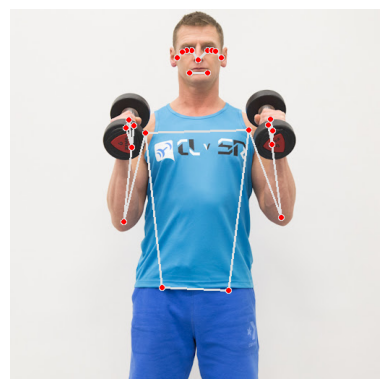

In [5]:
# Load a sample image to understand pose detection

pose = PoseEstimator()
image_path = os.path.abspath("D:/gym_pose_tracking/images/bicep_curl.jpg")
image = cv2.imread(image_path)
results = pose.process(image)
pose.draw_landmarks(image, results)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [6]:
# Calculate the angle between three key points (shoulder, elbow, wrist)
point_a = [1, 2]
point_b = [3, 4]
point_c = [5, 6]
angle = calculate_angle(point_a, point_b, point_c)
print(f"Calculated Angle: {angle:.2f}°")

Calculated Angle: 180.00°


Bicep Curls

In [15]:
# Demonstrating how reps are counted dynamically based on joint angles
counter = 0
stage = "down"
angles = [170, 165, 100, 50, 25, 175, 170, 100, 50, 25, 180, 170, 100, 50, 25, 175, 160, 100, 50, 20, 1175, 180]  # Simulated angles
for angle in angles:
    stage, counter = count_reps(angle, stage, counter)
print(f"Total reps counted: {counter}")

Total reps counted: 4


Shoulder Press

In [20]:
# Simulated shoulder press angles (real data would come from pose estimation)
counter = 0
stage = "down"
angles = [90, 95, 100, 150, 170, 175, 180, 90, 95, 170, 180]  # Example movement

for angle in angles:
    stage, counter = count_shoulder_press(angle, stage, counter)

print(f"Total shoulder press reps counted: {counter}")

Total shoulder press reps counted: 0


Lateral Raise

In [21]:
# Simulated lateral raise angles (real data would come from pose estimation)
counter = 0
stage = "down"
angles = [15, 25, 50, 80, 95, 100, 120, 15, 90, 95, 110, 10]  # Example movement

for angle in angles:
    stage, counter = count_lateral_raise(angle, stage, counter)

print(f"Total lateral raise reps counted: {counter}")

Total lateral raise reps counted: 2


In [ ]:
# Calculate the angles
def calculate_angle(a, b, c):
    """
    Calculate the angle between three points.
    :param a: First point (shoulder)
    :param b: Second point (elbow)
    :param c: Third point (wrist)
    :return: Angle in degrees
    """
    a = np.array(a)  # Shoulder
    b = np.array(b)  # Elbow
    c = np.array(c)  # Wrist
    
    radians = np.arctan2(c[1] - b[1], c[0] - b[0]) - np.arctan2(a[1] - b[1], a[0] - b[0])
    angle = np.abs(radians * 180.0 / np.pi)
    
    if angle > 180.0:
        angle = 360.0 - angle

    return angle

cap = cv2.VideoCapture(0)

# Curl counter variables
counter = 0
stage = None

## Setup Mediapipe instance
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame = cv2.flip(frame, 1)

        # Recolor image to RGB
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False

        # Make detection
        results = pose.process(image)

        # Recolor back to BGR
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        # Extract landmarks
        try:
            if results.pose_landmarks:
                landmarks = results.pose_landmarks.landmark

                # Get mirrored coordinates for the left side (mirrored as right side)
                shoulder = [1 - landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x, 
                            landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y]
                elbow = [1 - landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].x, 
                         landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].y]
                wrist = [1 - landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].x, 
                         landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].y]

                # Calculate angle
                angle = calculate_angle(shoulder, elbow, wrist)

                # Visualize angle
                cv2.putText(image, str(int(angle)), 
                            tuple(np.multiply(elbow, [640, 480]).astype(int)), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA)

                # Curl counter logic
                if angle > 160:
                    stage = "down"
                if angle < 30 and stage == "down":
                    stage = "up"
                    counter += 1
                    print(counter)

        except:
            pass

        # Render curl counter
        # Setup status box
        cv2.rectangle(image, (0, 0), (225, 73), (245, 117, 16), -1)

        # Rep data
        cv2.putText(image, 'REPS', (15, 12), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
        cv2.putText(image, str(counter), 
                    (10, 60), 
                    cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 2, cv2.LINE_AA)

        # Stage data
        cv2.putText(image, 'STAGE', (65, 12), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
        cv2.putText(image, str(stage), 
                    (60, 60), 
                    cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 2, cv2.LINE_AA)

        # Render detections
        if results.pose_landmarks:
            mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                      mp_drawing.DrawingSpec(color=(245, 117, 66), thickness=2, circle_radius=2),
                                      mp_drawing.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2))

        cv2.imshow('Mediapipe Feed (Mirrored)', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()


1
2
3
4
5
6
7
8
9
10
